In [11]:
'''A jupyter notebook comparing the learning the state variables
when the particle filter is specified with movement and no movement. 
'''

'A jupyter notebook comparing the learning the state variables\nwhen the particle filter is specified with movement and no movement. \n'

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from epymorph.forecasting.likelihood import Poisson,Gaussian,NegativeBinomial
from epymorph.attribute import NamePattern
from epymorph.kit import *

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.simulation import Context
from epymorph.adrio import acs5, us_tiger
from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck

In [13]:
my_rng = np.random.default_rng(1)
'''Generate a random time dependent beta'''
log_beta_damping = 1 / 35
log_beta_mean = np.log(0.22)
log_beta_standard_deviation = 0.30
initial_log_beta = np.log(0.2)

delta_t = 1. 

A = np.exp(-log_beta_damping * delta_t)
M = log_beta_mean * (np.exp(-log_beta_damping * delta_t) - 1)
C = log_beta_standard_deviation * np.sqrt(1-np.exp(-2*log_beta_damping * delta_t))

sim_time_frame = TimeFrame.of("2015-01-01", 365)

log_beta = np.zeros((sim_time_frame.duration_days,))
log_beta[0] = initial_log_beta

for day in range(1,sim_time_frame.duration_days): 
    log_beta[day] = A * log_beta[day-1] - M + C * my_rng.normal()

beta = np.exp(log_beta)

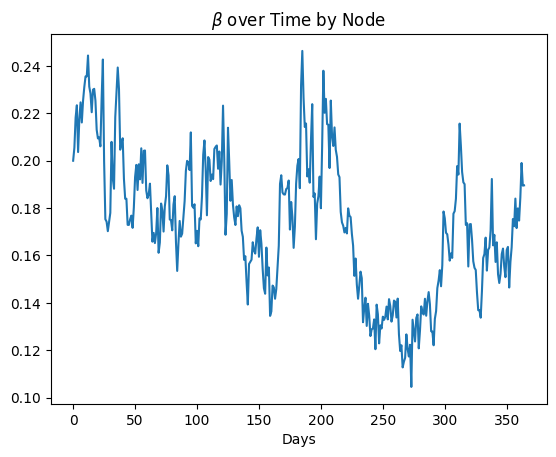

In [14]:
plt.title('$\\beta$ over Time by Node')
plt.xlabel('Days')
plt.plot(beta)

In [15]:
rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=CountyScope.in_counties(["King, WA","Whatcom, WA","Pierce, WA","Snohomish, WA"], year=2015),
    # Create a SingleLocation initializer
    init=init.SingleLocation(location=0, seed_size=100),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
    params={
        "beta": beta,
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "commuter_proportion":0.50,
        "hospitalization_prob":1/100,
        "hospitalization_duration":7.5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

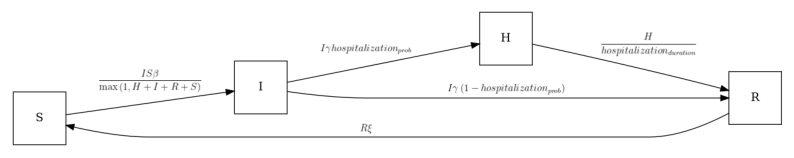

In [16]:
rume.ipm.diagram()

In [17]:
# Construct a simulator for the RUME
sim = BasicSimulator(rume)

# Run inside a sim_messaging context to display a nice progress bar
with sim_messaging():
    # Run and save the simulation Output object for later
    out = sim.run(
        # Use a seeded RNG (for the sake of keeping this notebook's results consistent)
        # This parameter is optional; by default a new RNG is constructed for each run
        # using numpy's default_rng
        rng_factory=default_rng(1)
    )

Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.598s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-12-31 (365 days)
• 4 geo nodes
  |####################| 100%                     
Runtime: 0.406s


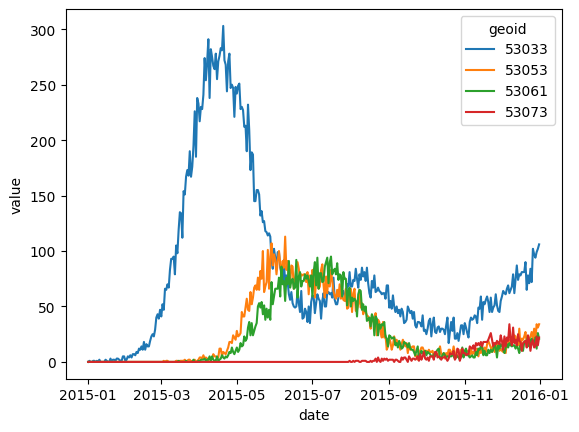

In [18]:
# Plot the compartment values in States throughout the simulation.
from epymorph.adrio import csv
from epymorph.tools.data import munge
import seaborn as sns


cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I->H"),
    time=rume.time_frame.select.all().group("day").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

sns.lineplot(data=cases_df,x='date',y='value',hue='geoid')

cases_df.to_csv('pf_vignettes/synthetic_data.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='pf_vignettes/synthetic_data.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

In [19]:
num_realizations = 100

pf_scope = CountyScope.in_counties(["King, WA","Whatcom, WA","Pierce, WA","Snohomish, WA"],year=2015)

pf_rume_no_movement = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.No(),
    # Describe the geographic scope of our simulation:
    scope=pf_scope,
    # Create a SingleLocation initializer
    init=init.RandomLocationsAndRandomSeed(4,1000),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
        params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "commuter_proportion":0.50,
        "hospitalization_prob":1/100,
        "hospitalization_duration":7.5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=pf_rume_no_movement.scope.select.all(),
        time=pf_rume_no_movement.time_frame.select.all().group("day").agg(),
        quantity=pf_rume_no_movement.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}


particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(pf_rume_no_movement,num_realizations,unknown_params = my_unknown_params),
        observations=my_observations,
        save_trajectories=True,
    )


In [20]:
particle_filter_output_no_movement = particle_filter_simulator.run(rng=my_rng)

Observation: 0, Label: 2015-01-01, Time Frame: 2015-01-01 (1D), 
Observation: 1, Label: 2015-01-02, Time Frame: 2015-01-02 (1D), 
Observation: 2, Label: 2015-01-03, Time Frame: 2015-01-03 (1D), 
Observation: 3, Label: 2015-01-04, Time Frame: 2015-01-04 (1D), 
Observation: 4, Label: 2015-01-05, Time Frame: 2015-01-05 (1D), 
Observation: 5, Label: 2015-01-06, Time Frame: 2015-01-06 (1D), 
Observation: 6, Label: 2015-01-07, Time Frame: 2015-01-07 (1D), 
Observation: 7, Label: 2015-01-08, Time Frame: 2015-01-08 (1D), 
Observation: 8, Label: 2015-01-09, Time Frame: 2015-01-09 (1D), 
Observation: 9, Label: 2015-01-10, Time Frame: 2015-01-10 (1D), 
Observation: 10, Label: 2015-01-11, Time Frame: 2015-01-11 (1D), 
Observation: 11, Label: 2015-01-12, Time Frame: 2015-01-12 (1D), 
Observation: 12, Label: 2015-01-13, Time Frame: 2015-01-13 (1D), 
Observation: 13, Label: 2015-01-14, Time Frame: 2015-01-14 (1D), 
Observation: 14, Label: 2015-01-15, Time Frame: 2015-01-15 (1D), 
Observation: 15, Lab

In [21]:
context = Context.of(
    scope=pf_rume_no_movement.scope,
    # We fetch data starting from the first fitting date to match the first nowcast.
    time_frame=pf_rume_no_movement.time_frame,
    rng=my_rng,
)
real_data_result = (
    my_observations.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]

real_data_dates = real_data_result["date"][:, 0]

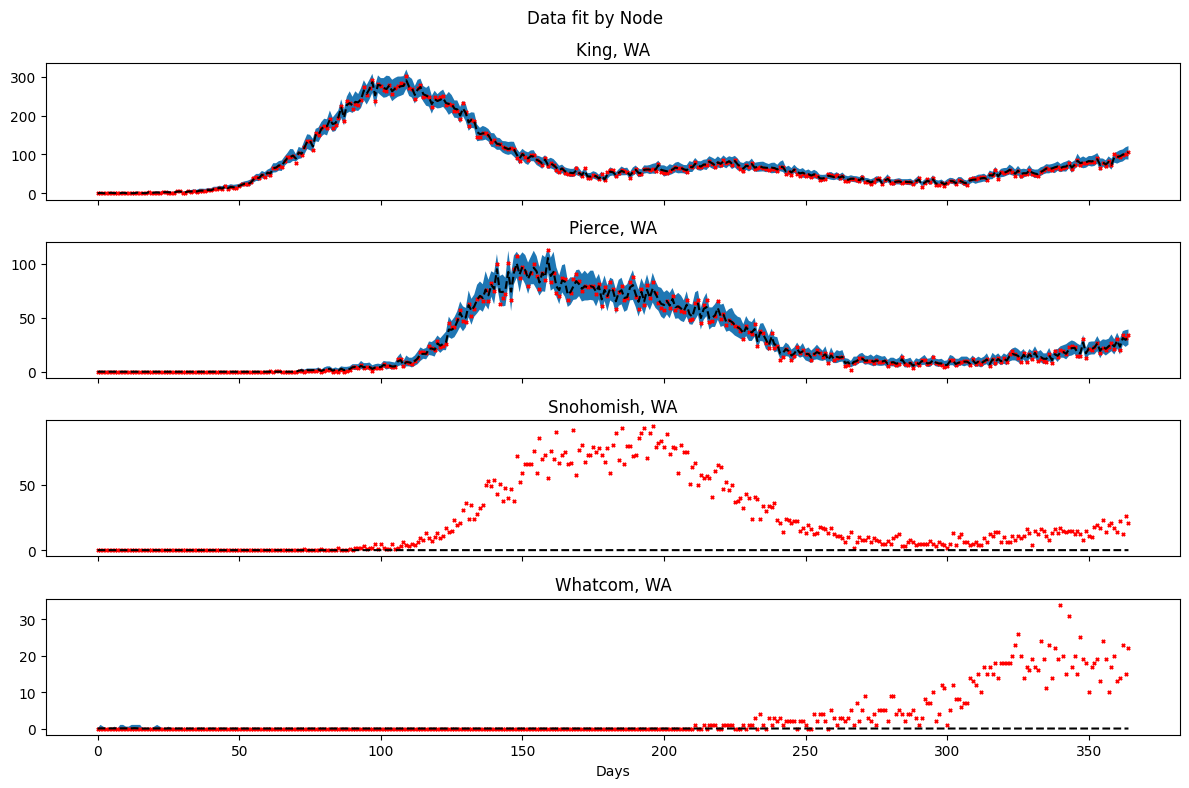

In [22]:
import matplotlib.pyplot as plt

t_range = np.arange(pf_rume_no_movement.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)


plt.suptitle('Data fit by Node')
for node in range(pf_rume_no_movement.scope.nodes):
        upper = np.percentile(particle_filter_output_no_movement.posterior_values[:,:,node,:],97.5,axis = 1)[:,0]
        lower = np.percentile(particle_filter_output_no_movement.posterior_values[:,:,node,:],2.5,axis = 1)[:,0]
        data_mean = np.mean((particle_filter_output_no_movement.posterior_values[:,:,node,:]),axis = 1)
        ax[node].set_title(f'{pf_rume_no_movement.scope.labels[node]}')
        ax[node].plot(data_mean,'--',label = 'mean',color = 'black')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_data[:,node],marker = 'x',color = 'red',s= 5)
ax[-1].set_xlabel('Days')
fig.tight_layout()


In [27]:
pf_rume_movement = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=pf_scope,
    # Create a SingleLocation initializer
    init=init.RandomLocationsAndRandomSeed(4,1000),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":0.1,
        "xi":1/90,
        "phi":5,
        "commuter_proportion":0.50,
        "hospitalization_prob":1/100,
        "hospitalization_duration":7.5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=pf_rume_movement.scope.select.all(),
        time=pf_rume_movement.time_frame.select.all().group("day").agg(),
        quantity=pf_rume_movement.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}


particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(pf_rume_movement,num_realizations,unknown_params = my_unknown_params),
        observations=my_observations,
        save_trajectories=True,
    )


In [28]:
particle_filter_output_movement = particle_filter_simulator.run(rng=my_rng)

Observation: 0, Label: 2015-01-01, Time Frame: 2015-01-01 (1D), 
Observation: 1, Label: 2015-01-02, Time Frame: 2015-01-02 (1D), 
Observation: 2, Label: 2015-01-03, Time Frame: 2015-01-03 (1D), 
Observation: 3, Label: 2015-01-04, Time Frame: 2015-01-04 (1D), 
Observation: 4, Label: 2015-01-05, Time Frame: 2015-01-05 (1D), 
Observation: 5, Label: 2015-01-06, Time Frame: 2015-01-06 (1D), 
Observation: 6, Label: 2015-01-07, Time Frame: 2015-01-07 (1D), 
Observation: 7, Label: 2015-01-08, Time Frame: 2015-01-08 (1D), 
Observation: 8, Label: 2015-01-09, Time Frame: 2015-01-09 (1D), 
Observation: 9, Label: 2015-01-10, Time Frame: 2015-01-10 (1D), 
Observation: 10, Label: 2015-01-11, Time Frame: 2015-01-11 (1D), 
Observation: 11, Label: 2015-01-12, Time Frame: 2015-01-12 (1D), 
Observation: 12, Label: 2015-01-13, Time Frame: 2015-01-13 (1D), 
Observation: 13, Label: 2015-01-14, Time Frame: 2015-01-14 (1D), 
Observation: 14, Label: 2015-01-15, Time Frame: 2015-01-15 (1D), 
Observation: 15, Lab

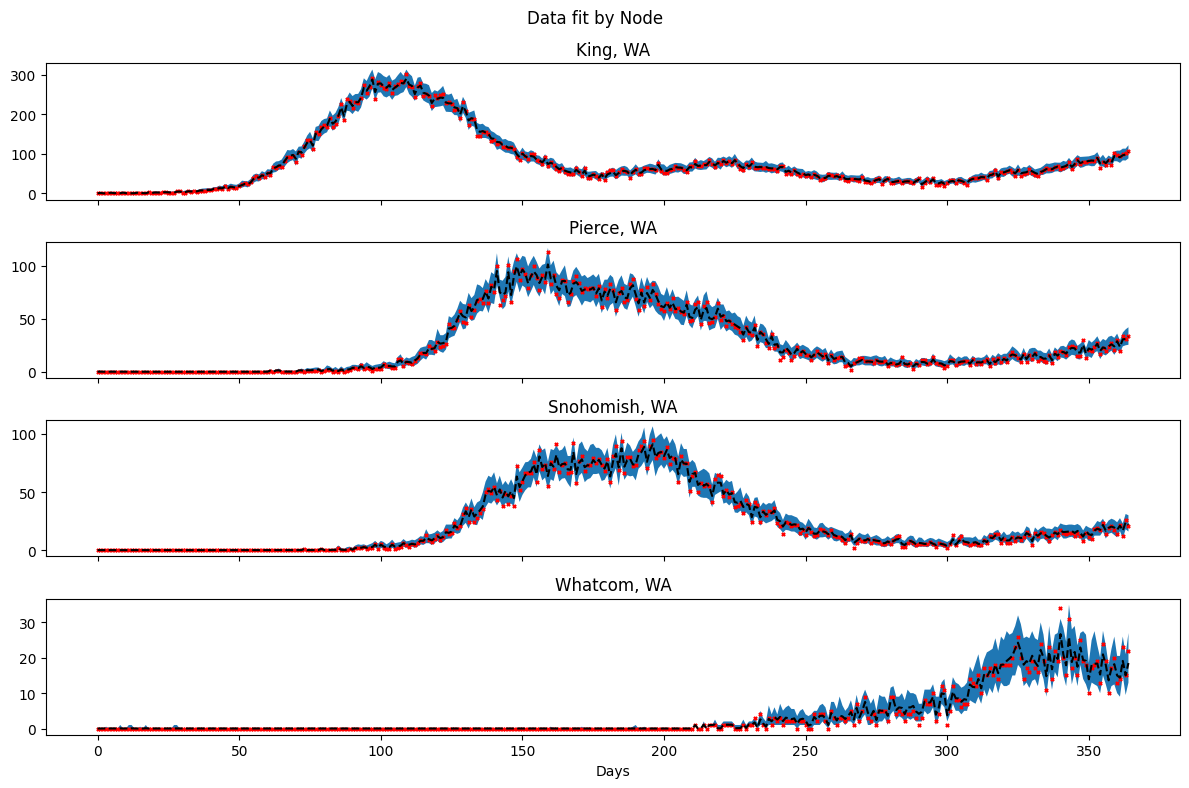

In [29]:
t_range = np.arange(pf_rume_movement.time_frame.duration_days)

fig,ax = plt.subplots(4,figsize = (12,8),sharex=True)


plt.suptitle('Data fit by Node')
for node in range(pf_rume_no_movement.scope.nodes):
        upper = np.percentile(particle_filter_output_movement.posterior_values[:,:,node,:],97.5,axis = 1)[:,0]
        lower = np.percentile(particle_filter_output_movement.posterior_values[:,:,node,:],2.5,axis = 1)[:,0]
        data_mean = np.mean((particle_filter_output_movement.posterior_values[:,:,node,:]),axis = 1)
        ax[node].set_title(f'{pf_rume_movement.scope.labels[node]}')
        ax[node].plot(data_mean,'--',label = 'mean',color = 'black')
        ax[node].fill_between(t_range,lower,upper)
        ax[node].scatter(t_range,real_data[:,node],marker = 'x',color = 'red',s= 5)
ax[-1].set_xlabel('Days')
fig.tight_layout()